# Project 2: Web Traffic Analysis
**This is the second of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

## Introduction
In this project your task is to analyze a stream of log entries. A log entry consists of an [IP address](https://en.wikipedia.org/wiki/IP_address) and a [domain name](https://en.wikipedia.org/wiki/Domain_name). For example, a log line may look as follows:

`192.168.0.1 somedomain.dk`

One log line is the result of the event that the domain name was visited by someone having the corresponding IP address. Your task is to analyze the traffic on a number of domains. Counting the number of unique IPs seen on a domain doesn't correspond to the exact number of unique visitors, but it is a good estimate.

Specifically, you should answer the following questions from the stream of log entries.

- How many unique IPs are there in the stream?
- How many unique IPs are there for each domain?
- How many times was IP X seen on domain Y? (for some X and Y provided at run time)

**The answers to these questions can be approximate!**

You should also try to answer one or more of the following, more advanced, questions. The answers to these should also be approximate.

- How many unique IPs are there for the domains $d_1, d_2, \ldots$?
- How many times was IP X seen on domains $d_1, d_2, \ldots$?
- What are the X most frequent IPs in the stream?

You should use algorithms and data structures that you've learned about in the lectures, and you should provide your own implementations of these.

Furthermore, you are expected to:

- Document the accuracy of your answers when using algorithms that give approximate answers
- Argue why you are using certain parameters for your data structures

This notebook is in three parts. In the first part you are given an example of how to read from the stream (which for the purpose of this project is a remote file). In the second part you should implement the algorithms and data structures that you intend to use, and in the last part you should use these for analyzing the stream.

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You may modify this if you want to, but your solution should remain parametrized, so that your notebook can be run without having to consume the entire file.

In [1]:
import urllib

def stream(n):
    i = 0
    with urllib.request.urlopen('https://files.dtu.dk/fss/public/link/public/stream/read/traffic?linkToken=3pLwj8eS8I_MkvCK&itemName=traffic') as f:
        for line in f:
            element = line.rstrip().decode("utf-8")
            yield element
            i += 1
            if i == n:
                break

In [2]:
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)

## Data structures

### Algorithms

**Hyperloglog algorithm**

The hyperloglog algorithm is utilized to approximate the amount of unique elements from a (potentially large) stream, while avoiding the allocation of alot of memory. The algorithm is implemented, following the presented principles in [F. Flajolet, Philippe, Fusy, Eric, Gandouet, Oliver, Meunier, “HyperLogLog: The analysis of a near-optimal cardinality estimation algorithm,” HAL, vol. 2, p. 21, 2015.], where the parameters b and m (which determines the complexity of the sketch) are decided based on an error argument. Moreover, it is decided to implement the algorithm as a class, HyperLogLog, making it possible to instantiate the algorithm as an object for the analysis.

In [3]:
import mmh3
import math

class HyperLogLog():
    def __init__(self, error):
        # Calculate parameters based on error
        self.b = int(math.log(1.04/error**2, 2))
        self.m = 2**self.b
        
        # Set error correction based on b
        self.a = self.alpha(self.b)
        
        # Create empty bucket array
        self.M = [0 for i in range(self.m+1)]
        
    def alpha(self, b):
        # Error correction
        if b == 4:
            return 0.673
        elif b == 5:
            return 0.697
        elif b == 6:
            return 0.709
        else:
            return 0.7213 / (1.0 + 1.079 / self.m)
        
    def add(self, value):
        # Find registry value and bucket value
        x = '{:032b}'.format(mmh3.hash(value))
        
        #j = 1+int(x[:self.b],2)
        j = int(x, 2) & (self.m - 1)

        w = 1 + x[self.b:].find("1")
        
        self.M[j] = max(self.M[j], w)
        
    def result(self):
        # Return the cardinality
        Z = 1 / sum([2**-self.M[j] for j in range(self.m)])
    
        return int(self.a * self.m**2 * Z)

**CountMin algorithm**

The CountMin algorithm is utilized to approxiamtely count the occurence of specific elements from a (potentially large) stream, while avoiding the allocation of alot of memory. The algorithm is implemented, following the presented principles in [S. Cormode, Graham, Muthukristnan, “An Improved Data Stream Summary: The Count-Min Sketch and its Application,” Elsevier Sci., p. 18, 2003.], where the parameters d and w (which determines the complexity of the sketch) are decided based on an error argument. Moreover, it is decided to implement the algorithm as a class, CountMin, making it possible to instantiate the algorithm as an object for the analysis.

In [4]:
import mmh3
import math
import random
import numpy as np

class CountMin():
    def __init__(self, error):
        # Create array by error
        self.w = int(2/(error/100))
        self.d = int(math.log(error/100)/math.log(1/2))

        self.M = np.zeros((self.d, self.w))

        # Create random seeds for the hashing
        self.seeds = [random.randint(1,self.w*self.d) for i in range(self.d)]
        
    def add(self, value):
        # Fill value into the matrix
        for i in range(self.d):
            self.M[i][mmh3.hash(value, seed=self.seeds[i]) % self.w] += 1
 
    def result(self, query):
        # Return lowest value fron the matrix
        min_value = None
        for i in range(self.d):
            index = self.M[i][mmh3.hash(query, seed=self.seeds[i]) % self.w]
            if not min_value:
                min_value = index
            min_value = min(min_value, index)
            
        return min_value

### Additional functions and classes

Before being able to answer the questions for the analysis, some additional functions and classes are needed.
The functions implemented here are for documenting the accuracy of the approximate answers retrieved from the algorithms. First, we implement a get_accuracy function.

In [5]:
def get_accuracy(obs_value, true_value):
    # Returns the accuracy
    result = (100-abs(obs_value-true_value)/true_value*100)
    
    return result

A class, StreamSampler, is implemented, which serves the purpose of storing results at specific iteration points (given as argument, percentage), such that we obtain sample data throughout the stream.

In [6]:
class StreamSampler():
    def __init__(self, n, percentage):
        self.sample = list()
        self.percentage = percentage
        self.c = int()
        self.n = n
        
    def time_for_sample(self):
        # True when point should be stored
        self.c += 1
        
        if self.c % int(self.n*self.percentage) == 0 or self.c == self.n-1:
            return True
        else:
            return False
        
    def get_sample(self):
        # Returns the stored sample
        return self.sample
        
    def add(self, result):
        # Add value to the sample
        self.sample.append(result)

A function for plotting the accuracy (with arguments: observed sample (obtained using our algorithm) and the true sample (containing true values)) is made aswell.

In [7]:
import matplotlib.pyplot as plt

def plot_accuracy(obs_sample, true_sample):
    y = list()
    
    # Calculate the accuracy based of observation values and true values
    for obs_value, true_value in zip(obs_sample.get_sample(), true_sample.get_sample()):
        y.append(get_accuracy(obs_value, true_value))

    x = [STREAM_SIZE*(i/10) for i in range(len(y))]

    # Plots x, y values with additional configurations
    plt.style.use('seaborn-darkgrid')
    
    plt.figure(figsize=(10,5))
    plt.plot(x, y, marker='o')
    plt.xlabel("Stream size")
    plt.ylabel("Accuracy (%)")
    
    plt.ylim(0, 110)
    plt.xlim(0, STREAM_SIZE+1)

    plt.show()

## Analysis

Libraries are imported for the analysis

In [8]:
import statistics
from collections import Counter

The desired stream size for the analysis is set to 200000, since we want a stream which is not too small for testing

In [9]:
STREAM_SIZE = 200000

A function to retrieve the generator is created. The global variable STREAM_SIZE is set as default , while it is still possible to call for a smaller stream size than the default size.

In [10]:
def get_stream(n = STREAM_SIZE):
    # Returns a stream of size n
    web_traffic_stream = stream(n)
    
    return web_traffic_stream

### How many unique IPs are there in the stream?

The Hyperloglog algorithm is used to answer this question. An error of 0.05 (5%) is choosen, which is to be considered a appropriate value, considering the parameters determined from this (as described earlier).

In [11]:
obs_sample = StreamSampler(STREAM_SIZE, 0.1)

hll = HyperLogLog(0.05)
for element in get_stream():
    # Fill hyperlolog
    ip_address = element.split("\t")[0]
    hll.add(ip_address)
    
    # Sampling
    if obs_sample.time_for_sample():
        obs_sample.add(hll.result())

# Display last value of the sampling
print("Result:", obs_sample.get_sample()[-1])

Result: 196895


#### Documentation of accuracy

To be able to document the accuracy, the true value is determined

In [12]:
true_sample = StreamSampler(STREAM_SIZE, 0.1)

unique_counter = list()

for element in get_stream():
    # Fill list to count uniques
    ip_address = element.split("\t")[0]
    unique_counter.append(ip_address)
    
    # Sampling
    if true_sample.time_for_sample():
        true_sample.add(len(Counter(unique_counter).keys()))

# Display last value of the sampling
print("Result:", true_sample.get_sample()[-1])

Result: 199979


The accuracy is then plotted for each 10% of the elements throughout the stream of size 200000

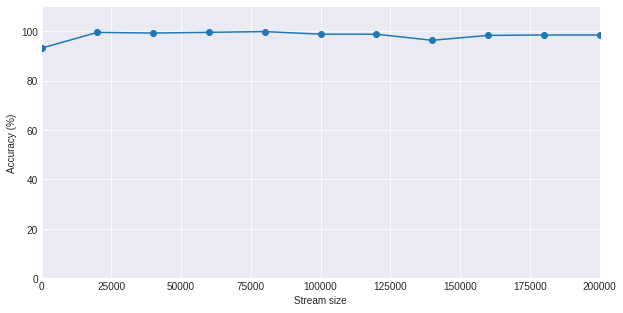

In [13]:
plot_accuracy(obs_sample, true_sample)

From this, it is apparent that the algorithm satisfies the 5% error which has been specified for this specific query.
Also, it is noticeable that almost all IPs in the stream are unique. 

### How many unique IPs are there for each domain?

The Hyperloglog algorithm is used to answer this question. First off, each domain is hashed to avoid potential infinite memory usage. Then Hyperloglog is used to count the unique IPs for each domain. Also, an error of 0.05 (5%) is choosen for the HLL, which is to be considered a appropriate value, considering the parameters determined from this (as described earlier). 

In [14]:
obs_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]

    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    # Hyperloglog to count uniques in each domain
    if domain not in domains:
        domains[domain] = HyperLogLog(0.05)
    
    domains[domain].add(ip_address)

    # Sampling
    if obs_sample.time_for_sample():
        sum_uniques = sum([v.result() for v in domains.values()])
        len_domains = len(domains)
        
        obs_sample.add(sum_uniques / len_domains)
        
# Display last value of the sampling
print("Result:", round(obs_sample.get_sample()[-1],2))

Result: 22671.56


#### Documentation of accuracy

To be able to document the accuracy, the true value is determined

In [15]:
true_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    if domain not in domains:
        domains[domain] = list()
        
    domains[domain].append(ip_address)

    # Sampling
    if true_sample.time_for_sample():
        uniques = int()
        
        for k, v in domains.items():
            uniques += len(Counter(v).keys())

        true_sample.add(uniques / len(domains))

# Display last value of the sampling
print("Result:", round(true_sample.get_sample()[-1],2))

Result: 22221.11


The accuracy is then plotted for each 10% of the elements throughout the stream of size 200000

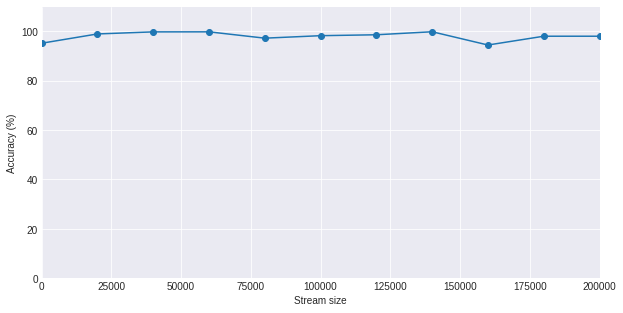

In [16]:
plot_accuracy(obs_sample, true_sample)

From this, it is apparent that the algorithm satisfies the 5% error which has been specified for this specific query.

### How many times was IP X seen on domain Y? (for some X and Y provided at run time)

The first element of the stream is displayed. The IP and domain for this element will be used to answer the following question.

In [17]:
domain_query = None
ip_query = None

for element in get_stream(1):
    print(element)
    ip_address, domain = element.split("\t")
    
    ip_query = ip_address 
    domain_query = domain

41.17.190.142	wikipedia.org


The CountMin algorithm is used to answer this question. An error of 0.01 (1%) is choosen, which is to be considered a appropriate value, considering the parameters determined from this (as described earlier). Also, the error is choosen to be smaller (1%) since it has been found in the first question that almost all IPs in the stream are unique. Thus, it is not expected that the same IP X is seen many times on a specific domain Y.

In [18]:
obs_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    # Count occurences with countmin
    if domain not in domains:
        domains[domain] = CountMin(0.01)
    
    domains[domain].add(ip_address)
    
    # Sampling
    if obs_sample.time_for_sample():
        obs_sample.add(domains[mmh3.hash(domain_query)].result(ip_query))

# Display last value of the sampling
print(domain_query, ip_query)
print("Result:", obs_sample.get_sample()[-1])

wikipedia.org 41.17.190.142
Result: 4.0


#### Documentation of accuracy

To be able to document the accuracy, the true value is determined

In [19]:
true_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    # Count the occurences in domains
    if domain not in domains:
        domains[domain] = dict()
        
    if ip_address not in domains[domain]:
        domains[domain][ip_address] = int()
        
    domains[domain][ip_address] += 1
    
    # Sampling
    if true_sample.time_for_sample():
        if ip_query in domains[mmh3.hash(domain_query)]:
            true_sample.add(domains[mmh3.hash(domain_query)][ip_query])
        else:
            true_sample.add(0)

# Display last value of the sampling
print(domain_query, ip_query)
print("Result:", true_sample.get_sample()[-1])

wikipedia.org 41.17.190.142
Result: 1


The accuracy is then plotted for each 10% of the elements throughout the stream of size 200000

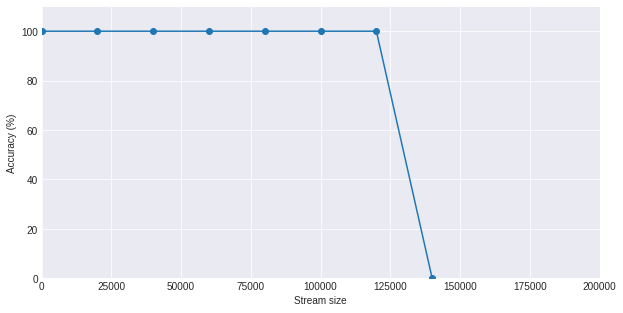

In [20]:
plot_accuracy(obs_sample, true_sample)

It is apparent that the accuracy suddenly drops. Let's look at the actual values (from the algorithm and the true values) which we get throughout the stream

In [21]:
print("Observed values(algorithm):", list(map(lambda x: int(x), obs_sample.get_sample())))
print("True values in the stream:", true_sample.get_sample())

Observed values(algorithm): [1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 4]
True values in the stream: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Looking at this, it is clear why the accuracy suddenly drops. As expected, the true values are very small, and thus there is not much 'room' for errors when the algorithm is estimating, in regards to the calculated accuracy. 

### How many unique IPs are there for the domains 𝑑1,𝑑2,…?

The Hyperloglog algorithm is used to answer this question. An error of 0.05 (5%) is choosen, which is to be considered a appropriate value, considering the parameters determined from this (as described earlier).

In [22]:
obs_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    # Count uniques for each domain by hyperloglog
    if domain not in domains:
        domains[domain] = HyperLogLog(0.05)
    
    domains[domain].add(ip_address)

    # Sampling
    if obs_sample.time_for_sample():
        result = statistics.mean([x.result() for x in domains.values()])
        obs_sample.add(result)

In [23]:
# Print unique IPs foreach domain
c = int()
for k, v in domains.items():
    print("D{}: {} unique IP(s)".format(c, v.result()))
    c += 1

D0: 108520 unique IP(s)
D1: 25601 unique IP(s)
D2: 53012 unique IP(s)
D3: 916 unique IP(s)
D4: 5169 unique IP(s)
D5: 5241 unique IP(s)
D6: 2508 unique IP(s)
D7: 2537 unique IP(s)
D8: 540 unique IP(s)


#### Documentation of accuracy

To be able to document the accuracy, the true values are determined. The accuracy is calculated based on the mean of the results, obtained using the algorithm and the true values respectively.

In [24]:
true_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    # Uniques ip address count by each doamin
    if domain not in domains:
        domains[domain] = list()
    
    domains[domain].append(ip_address)

    # Sampling
    if true_sample.time_for_sample():
        result = statistics.mean([len(Counter(v).keys()) for _, v in domains.items()])
        true_sample.add(result)

In [25]:
# Print unique IPs foreach domain
c = int()
for k, v in domains.items():
    print("D{}: {} unique IP(s)".format(c, len(Counter(v).keys())))
    c += 1

D0: 104550 unique IP(s)
D1: 26155 unique IP(s)
D2: 51952 unique IP(s)
D3: 1059 unique IP(s)
D4: 5243 unique IP(s)
D5: 5181 unique IP(s)
D6: 2669 unique IP(s)
D7: 2664 unique IP(s)
D8: 517 unique IP(s)


The accuracy is then plotted for each 10% of the elements throughout the stream of size 200000

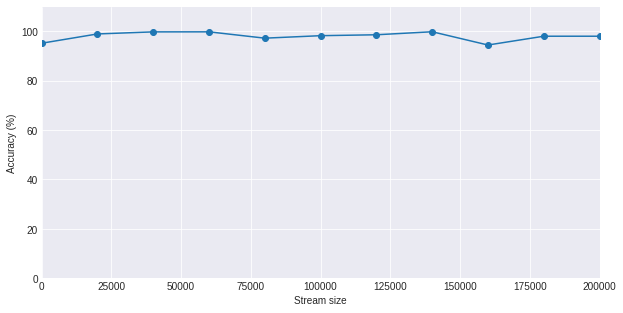

In [26]:
plot_accuracy(obs_sample, true_sample)

From this, it is apparent that the algorithm satisfies the 5% error which has been specified for this specific query.

### How many times was IP X seen on domains 𝑑1,𝑑2,…?

The CountMin algorithm is used to answer this question. An error of 0.1 (1%) is choosen, which is to be considered a appropriate value, considering the parameters determined from this (as described earlier). Also, the error is choosen to be smaller (1%) since it has been found in the first question that almost all IPs in the stream are unique. Thus, it is not expected that the same IP x is seen many times on the different domains.

In [27]:
ip_query = None

for element in get_stream(1):
    ip_query = element.split("\t")[0]
    
print(ip_query)

41.17.190.142


In [28]:
obs_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    # Count ips by countmin
    if domain not in domains:
        domains[domain] = CountMin(0.01)
    
    domains[domain].add(ip_address)
    
    # Sampling
    if obs_sample.time_for_sample():
        result = statistics.mean([v.result(ip_query) for _, v in domains.items()])
        obs_sample.add(result)

In [29]:
# Print unique IPs foreach domain
c = int()
for k, v in domains.items():
    print("D{}: {} unique IP(s)".format(c, v.result(ip_query)))
    c += 1

D0: 3.0 unique IP(s)
D1: 2.0 unique IP(s)
D2: 1.0 unique IP(s)
D3: 0.0 unique IP(s)
D4: 0.0 unique IP(s)
D5: 1.0 unique IP(s)
D6: 0.0 unique IP(s)
D7: 0.0 unique IP(s)
D8: 1.0 unique IP(s)


#### Documentation of accuracy

To be able to document the accuracy, the true values are determined. The accuracy is calculated based on the mean of the results obtained using the algorithm and the true values respectively.

In [30]:
true_sample = StreamSampler(STREAM_SIZE, 0.1)

domains = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    # Hash domain in case of high occurences of domains
    domain = mmh3.hash(element[1])
    
    # Count unique ips for each domain
    if domain not in domains:
        domains[domain] = dict()
        
    if ip_address not in domains[domain]:
        domains[domain][ip_address] = int()
        
    domains[domain][ip_address] += 1
        
    # Sampling
    if true_sample.time_for_sample():
        result = int()
        for key, value in domains.items():
            if ip_query in value:
                result += value[ip_query]
        true_sample.add(result)

In [31]:
# Print unique IPs foreach domain
c = int()
for key, value in domains.items():
    if ip_query not in value:
        value[ip_query] = 0
    print("D{}: {} unique IP(s)".format(c, value[ip_query]))
    c += 1

D0: 1 unique IP(s)
D1: 0 unique IP(s)
D2: 0 unique IP(s)
D3: 0 unique IP(s)
D4: 0 unique IP(s)
D5: 0 unique IP(s)
D6: 0 unique IP(s)
D7: 0 unique IP(s)
D8: 0 unique IP(s)


The accuracy is then plotted for each 10% of the elements throughout the stream of size 200000

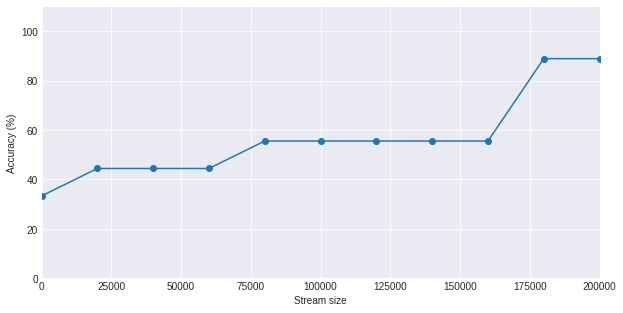

In [32]:
plot_accuracy(obs_sample, true_sample)

Looking at this, it is apparent that the accuracy is not that great throughout the stream. We have a scenario which is somewhat the same as in the question 'How many times was IP X seen on domain Y?'. Again, the true values are very small, and thus there is not much 'room' for errors when the algorithm is estimating, in regards to the calculated accuracy. 

### What are the X most frequent IPs in the stream?

The CountMin algorithm is used to answer this question. An error of 0.001 (0.1%) is choosen, which is to be considered a appropriate value, considering the parameters determined from this (as described earlier). Also, the error is choosen to be smaller (0.1%) since it has been found in the first question that almost all IPs in the stream are unique. Thus, it is not expected that the same IP X is seen many times. The CountMin algorithm is used such that an array of size k stores the maximum k elements found in the stream.

In [33]:
obs_sample = StreamSampler(STREAM_SIZE, 0.1)

#K-elements (X)
k = 5

# Element and amount list
table = [[str()] * k, [0] * k]

# Use count min algorithm on the stream
count_min = CountMin(0.001)

for element in get_stream():
    # Add ip address to count
    ip_address = element.split("\t")[0]
    count_min.add(ip_address)
    
    # Replace min value with higher
    current_count = count_min.result(ip_address)
    
    if min(table[1]) < current_count:
        idx = table[1].index(min(table[1]))
    
        table[0][idx] = ip_address
        table[1][idx] = current_count

    # Sampling
    if obs_sample.time_for_sample():
        obs_sample.add(statistics.mean(table[1]))

In [34]:
# Display maximum seen k elements
print("Most frequent IP(s)")
for ip, count in zip(table[0],table[1]):
    print(ip,count)

Most frequent IP(s)
188.127.109.87 2.0
91.140.120.76 2.0
152.84.55.111 2.0
63.159.77.71 2.0
140.98.93.101 2.0


#### Documentation of accuracy

To be able to document the accuracy, the true value is determined. The accuracy is calculated based on the mean of the occurences. The true values are found by sorting based on the occurences and retrieving the first x (k) elements of the sorted list. In comparison, when using the max seen occurences algorithm, the max occurences aren't sorted. Thus, if there are more elements of the same occurences than the X retrieved elements (which is to be expected in this case), we might have a problem. This might result in the two methods giving different results, but only in regards to the specific IPs, and not the frequencies.

In [35]:
true_sample = StreamSampler(STREAM_SIZE, 0.1)

domain = dict()

for element in get_stream():
    element = element.split("\t")
    
    ip_address = element[0]
    
    if ip_address not in domain:
        domain[ip_address] = int()
        
    domain[ip_address] += 1

    if true_sample.time_for_sample():
        result = statistics.mean(sorted(domain.values(), reverse=True)[:k])
        true_sample.add(result)

In [36]:
# Display most frequent values
for element in sorted(domain.keys(), key=domain.get, reverse=True)[:k]:
    print(element, domain[element])

121.93.192.192 2
188.127.109.87 2
154.113.126.169 2
91.140.120.76 2
156.159.143.146 2


The accuracy is then plotted for each 10% of the elements throughout the stream of size 200000

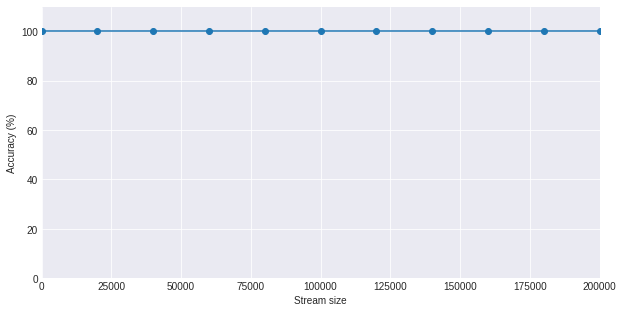

In [37]:
plot_accuracy(obs_sample, true_sample)

It is apparent that the two results (obtained using the algorithm and the true values respectively) indeed gives different results, but only in regards to the specific IPs, and not the frequencies.